# Load squared exponential approximation precomputed in data/*.json

In [1]:
import json
import numpy as np

# Exponential kernel
path_exp = "data/rq.json"

with open(path_exp, "r") as f:
    squared_approx = json.load(f)

# available decomposition sizes
squared_approx.keys()

dict_keys(['1', '2', '3', '4'])

In [117]:
decomp_size = 4
a_coeff = squared_approx[str(decomp_size)]['a']
b_coeff = np.exp(squared_approx[str(decomp_size)]['b'])

In [361]:
from kl_decomposition import kernel_fit, orthopoly
import numpy as np
import matplotlib.pyplot as plt

x, w = orthopoly.gauss_legendre_rule_multilevel(0.0, 1.0, 100, L=5, ratio=0.2)


def target_function(x): return np.exp(-10*x)


target_exp = target_function(x)
obj, grad, hess = kernel_fit.build_se_obj_grad_hess(x, w, target_exp)
exp_all_a, exp_all_b, exp_all_vals = kernel_fit.square_exp_approximations_newton(
    max_terms=5, precision=1e-6,
    x=x, w=w, target=target_exp,
    obj=obj, grad=grad, hess=hess, verbose=True)

a_coeff = exp_all_a[-1]
b_coeff = np.exp(exp_all_b[-1])
print(f"Final a_coeff: {a_coeff}, b_coeff: {b_coeff}")

n_terms= 1  obj=3.734633e-02
n_terms= 2  obj=1.124394e-02
n_terms= 3  obj=4.175972e-03
n_terms= 4  obj=1.755259e-03
n_terms= 5  obj=8.032308e-04
Final a_coeff: [0.12427804 0.32953451 0.28874683 0.16604086 0.07689031], b_coeff: [1.18459408e+01 4.33141564e+01 1.90217497e+02 1.15171121e+03
 1.39834319e+04]


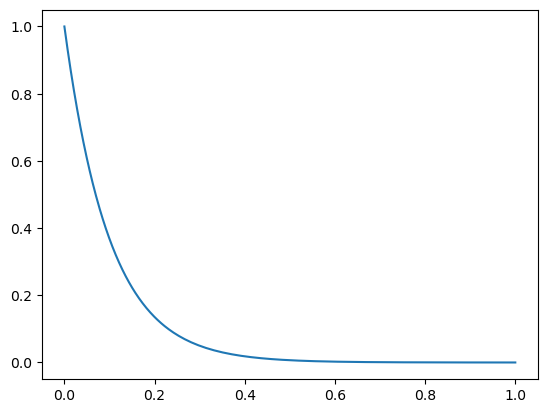

In [ ]:
plt.plot(x, target_exp, label='Target function')


## Compute all submatrices (on interval [0, 1])

In [106]:
from kl_decomposition import galerkin
comp_degree = 30
quad = 600
g = 4.0

A_all = []

for b in b_coeff:
    A_all.append(galerkin.assemble_duffy(f=b, degree=comp_degree, quad=quad, gx=g))

# Assemble block of A as operators for iterative eigenvalue decomposition

In [107]:
from kl_decomposition import kl_tensor

In [365]:
eigenvalues, eigenvectors = kl_tensor.spectral_blocks(A_all, a_coeff, 2, N_eval=100)

In [153]:
from typing import Dict, Tuple, List, Sequence
grid_axes = [np.linspace(0, 1, 100) for _ in range(3)]
eigvecs = eigenvectors
eigvals = eigenvalues

# -------------------------------------------------------------------- #
n = len(grid_axes)  # spatial dimensionality

# --- infer local basis sizes ---------------------------------------- #
size_even_block = next(
    v.shape[0] for bits, v in eigvecs.items() if all(b == 0 for b in bits)
)
d_even = int(round(size_even_block ** (1 / n)))

size_odd_block = next(
    v.shape[0] for bits, v in eigvecs.items() if all(b == 1 for b in bits)
)
d_odd = int(round(size_odd_block ** (1 / n)))

d_max = max(d_even, d_odd)


In [143]:
from kl_decomposition.orthopoly import leg_vals

In [156]:
n_poly = 60
phi_full: List[np.ndarray] = [leg_vals(n_poly, x) for x in grid_axes]
phi_even: List[np.ndarray] = [phi[::2] for phi in phi_full]
phi_odd: List[np.ndarray] = [phi[1::2] for phi in phi_full]

In [162]:
eigenvectors[(0,0,0)].reshape(30,30,30,20).shape

(30, 30, 30, 20)

In [157]:
phi_full[0].shape

(60, 100)

In [128]:
phi_full: List[np.ndarray] = [leg_vals(d_max, x) for x in grid_axes]
grid_axes

[array([0.        , 0.01666667, 0.03333333, 0.05      , 0.06666667,
        0.08333333, 0.1       , 0.11666667, 0.13333333, 0.15      ,
        0.16666667, 0.18333333, 0.2       , 0.21666667, 0.23333333,
        0.25      , 0.26666667, 0.28333333, 0.3       , 0.31666667,
        0.33333333, 0.35      , 0.36666667, 0.38333333, 0.4       ,
        0.41666667, 0.43333333, 0.45      , 0.46666667, 0.48333333,
        0.5       , 0.51666667, 0.53333333, 0.55      , 0.56666667,
        0.58333333, 0.6       , 0.61666667, 0.63333333, 0.65      ,
        0.66666667, 0.68333333, 0.7       , 0.71666667, 0.73333333,
        0.75      , 0.76666667, 0.78333333, 0.8       , 0.81666667,
        0.83333333, 0.85      , 0.86666667, 0.88333333, 0.9       ,
        0.91666667, 0.93333333, 0.95      , 0.96666667, 0.98333333,
        1.        ]),
 array([0.        , 0.01666667, 0.03333333, 0.05      , 0.06666667,
        0.08333333, 0.1       , 0.11666667, 0.13333333, 0.15      ,
        0.16666667, 0.1833

In [ ]:

# --- pre‑compute Legendre basis values ------------------------------ #
phi_full: List[np.ndarray] = [leg_vals(d_max, x) for x in grid_axes]
phi_even: List[np.ndarray] = [phi[:d_even] for phi in phi_full]
phi_odd: List[np.ndarray] = [phi[:d_odd] for phi in phi_full]

# -------------------------------------------------------------------- #
def _coeff_to_grid(coeff: np.ndarray, bits: Tuple[int, ...]) -> np.ndarray:
    """Evaluate *one* coefficient tensor on the tensor grid."""
    tensor = coeff
    for axis, bit in enumerate(bits):
        phi = phi_even[axis] if bit == 0 else phi_odd[axis]
        # contract coefficient index 0 with basis index 0; new grid axis appended
        tensor = np.tensordot(tensor, phi, axes=(0, 0))
    return tensor  # shape == (len(x₀), …, len(xₙ₋₁))

# -------------------------------------------------------------------- #
lambdas: List[float] = []
psi_grid: List[np.ndarray] = []

for bits, w_block in eigvals.items():
    v_block = eigvecs[bits]  # (block_dim, N_eval)
    # reconstruct per‑axis basis sizes for this block
    dims = tuple(d_even if b == 0 else d_odd for b in bits)
    for col, lam in enumerate(w_block):
        coeff = v_block[:, col].reshape(dims)
        psi = _coeff_to_grid(coeff, bits)
        lambdas.append(float(lam))
        psi_grid.append(psi)

# --- global descending sort ----------------------------------------- #
order = np.argsort(lambdas)[::-1]
eigenvalues = np.asarray(lambdas)[order]
eigenfunction_grid = [psi_grid[i] for i in order]

In [113]:
list(eigenvectors.keys())[0]

(0,)

In [116]:
eigenvectors[list(eigenvectors.keys())[0]].shape[0]

30

In [366]:
grid = np.linspace(0.0, 1.0, 100)
lambdas_sorted, psi_sorted = kl_tensor.evaluate_eigenfunctions(eigenvalues, eigenvectors, [grid, grid])

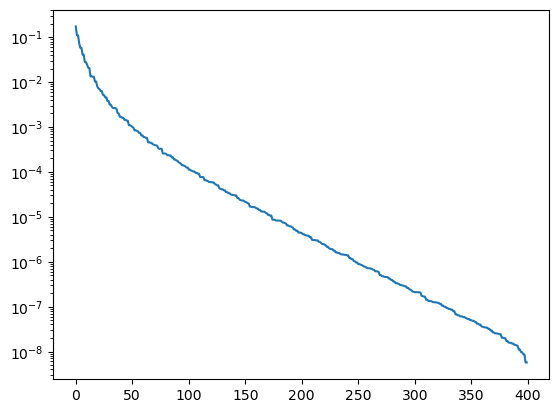

In [367]:
import matplotlib.pyplot as plt
plt.plot(lambdas_sorted)
plt.yscale('log')

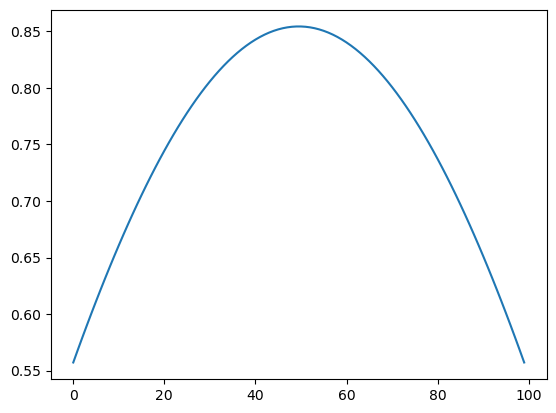

In [100]:
from kl_decomposition import orthopoly
x = np.linspace(0, 1, 100)
tmp = orthopoly.leg_vals(60,x)
tmp_o = tmp[::2,:]
i = 0

plt.plot(eigenvectors[(0,)][:, i] @ tmp_o * np.sqrt(eigenvalues[(0,)][i]))

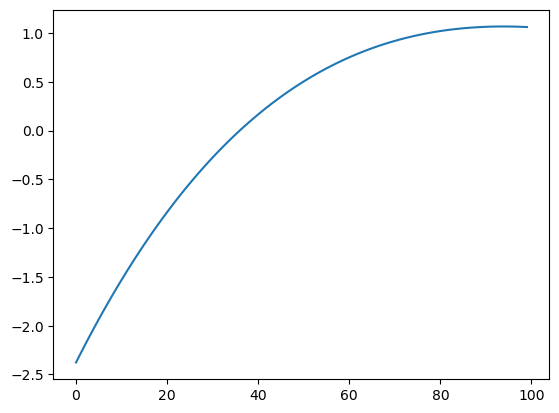

In [104]:
plt.plot(psi_sorted[2])

In [82]:
eigenvectors[(0,)][0].reshape(1, -1).shape

(1, 20)

In [ ]:
eigenvectors[(0,)][:,0]

(30,)

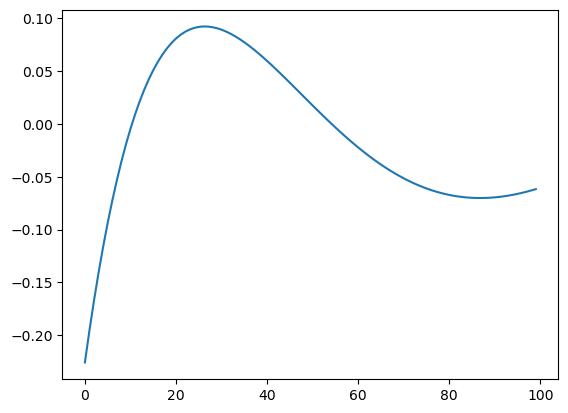

In [66]:
i = 4
plt.plot(lambdas_sorted[i]*psi_sorted[i] )

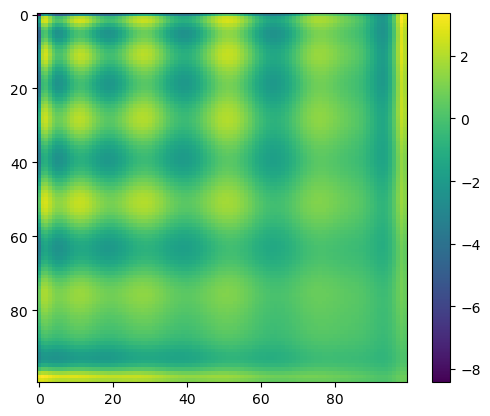

In [368]:
plt.imshow(psi_sorted[399])
plt.colorbar()

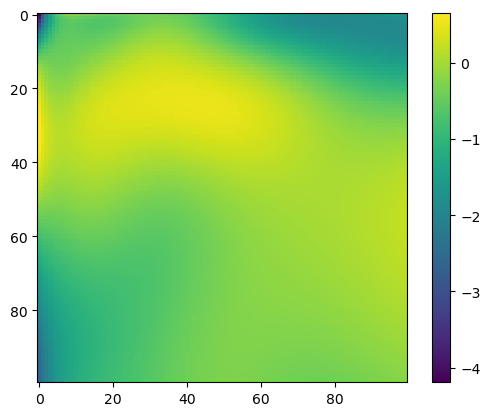

In [386]:
tmp = np.zeros_like(psi_sorted[0])

for lam, psi in zip(np.sqrt(lambdas_sorted), psi_sorted):
    tmp += np.random.randn() * lam * psi

plt.imshow(tmp)
plt.colorbar()